# Experiments

> The code implementing the experiments in the paper:
> 
> Davor Runje, Sharath M. Shankaranarayana. <i>Constrained Monotonic Neural Networks</i>. 40th International Conference on Machine Learning, 2023.


## Imports

In [ ]:
# | hide

try:
    import mono_dense_keras
except:
    !pip install mono_dense_keras
    import mono_dense_keras

In [ ]:
# | hide

from contextlib import contextmanager
from datetime import datetime
from os import environ
from pathlib import Path
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytest
import seaborn as sns
import tensorflow as tf
from keras_tuner import BayesianOptimization, Objective, Tuner
from numpy.typing import ArrayLike, NDArray
from tensorflow.keras import Model
from tensorflow.keras.backend import count_params
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.types.experimental import TensorLike

In [ ]:
# | hide

environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

## Monotonic Dense Layer


### Monotonic Dense Layer

This is an implementation of our Monotonic Dense Unit or Constrained Monotone Fully Connected Layer. The below is the figure from the paper for reference.

In the code, the variable `monotonicity_indicator` corresponds to **t** in the figure and the variable `activation_selector` corresponds to **s**. 

Parameters `convexity_indicator` and `epsilon` are used to calculate `activation_selector` as follows:
- if `convexity_indicator` is  -1 or 1, then `activation_selector` will have all elements 0 or 1, respectively.
- if `convexity_indicator` is `None`, then `epsilon` must have a value between 0 and 1 and corresponds to the percentage of elements of `activation_selector` set to 1.

![alternatvie text](images/mono-dense-layer-diagram.png)

In [ ]:
from mono_dense_keras import MonoDense, replace_kernel_using_monotonicity_indicator

In [ ]:
units = 18
activation = "relu"
batch_size = 9
x_len = 11

tf.keras.utils.set_random_seed(42)


def display_kernel(kernel: Union[tf.Variable, np.typing.NDArray[float]]) -> None:
    cm = sns.color_palette("coolwarm_r", as_cmap=True)

    df = pd.DataFrame(kernel)

    display(
        df.style.format("{:.2f}").background_gradient(cmap=cm, vmin=-1e-8, vmax=1e-8)
    )


x = np.random.default_rng(42).normal(size=(batch_size, x_len))

for monotonicity_indicator in [
    [1] * 4 + [0] * 4 + [-1] * 3,
    1,
    np.ones((x_len,)),
    -1,
    -np.ones((x_len,)),
]:
    print("*" * 120)
    mono_layer = MonoDense(
        units=units,
        activation=activation,
        monotonicity_indicator=monotonicity_indicator,
        activation_weights=(7, 7, 4),
    )
    print("input:")
    display_kernel(x)

    y = mono_layer(x)
    print(f"monotonicity_indicator = {monotonicity_indicator}")
    display_kernel(mono_layer.monotonicity_indicator)

    print("kernel:")
    with replace_kernel_using_monotonicity_indicator(
        mono_layer, mono_layer.monotonicity_indicator
    ):
        display_kernel(mono_layer.kernel)

    print("output:")
    display_kernel(y)
print("ok")

************************************************************************************************************************
input:


,0,1,2,3,4,5,6,7,8,9,10
0,0.30,-1.04,0.75,0.94,-1.95,-1.30,0.13,-0.32,-0.02,-0.85,0.88
1,0.78,0.07,1.13,0.47,-0.86,0.37,-0.96,0.88,-0.05,-0.18,-0.68
2,1.22,-0.15,-0.43,-0.35,0.53,0.37,0.41,0.43,2.14,-0.41,-0.51
3,-0.81,0.62,1.13,-0.11,-0.84,-0.82,0.65,0.74,0.54,-0.67,0.23
4,0.12,0.22,0.87,0.22,0.68,0.07,0.29,0.63,-1.46,-0.32,-0.47
5,-0.64,-0.28,1.49,-0.87,0.97,-1.68,-0.33,0.16,0.59,0.71,0.79
6,-0.35,-0.46,0.86,-0.19,-1.28,-1.13,-0.92,0.50,0.14,0.69,-0.43
7,0.16,0.63,-0.31,0.46,-0.66,-0.36,-0.38,-1.20,0.49,-0.47,0.01
8,0.48,0.45,0.67,-0.10,-0.42,-0.08,-1.69,-1.45,-1.32,-1.00,0.40


monotonicity_indicator = [1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1]


,0
0,1.00
1,1.00
2,1.00
3,1.00
4,0.00
5,0.00
6,0.00
7,0.00
8,-1.00
9,-1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.33,0.15,0.13,0.41,0.38,0.14,0.43,0.30,0.02,0.12,0.38,0.05,0.42,0.03,0.00,0.24,0.44,0.28
1,0.01,0.39,0.42,0.32,0.38,0.22,0.33,0.34,0.03,0.06,0.06,0.27,0.26,0.45,0.35,0.05,0.21,0.34
2,0.21,0.29,0.16,0.14,0.42,0.06,0.15,0.10,0.41,0.08,0.03,0.22,0.34,0.20,0.11,0.01,0.43,0.35
3,0.27,0.33,0.06,0.17,0.42,0.42,0.24,0.30,0.11,0.20,0.17,0.25,0.17,0.07,0.32,0.30,0.17,0.36
4,0.32,-0.25,0.12,-0.37,0.41,0.20,0.06,-0.28,-0.27,0.43,-0.41,-0.17,-0.24,-0.31,0.33,0.31,0.11,0.03
5,0.04,0.19,-0.02,-0.34,0.36,-0.12,0.28,0.32,-0.11,-0.40,0.41,0.30,0.06,-0.28,-0.27,0.23,-0.41,-0.12
6,0.35,-0.04,-0.28,0.16,-0.03,0.35,-0.03,-0.16,0.39,-0.36,-0.31,-0.18,0.02,-0.38,-0.40,0.39,0.35,-0.19
7,0.33,-0.34,0.11,-0.29,0.25,-0.21,0.11,0.08,-0.19,-0.39,0.01,0.10,0.39,-0.25,-0.37,-0.27,0.04,0.34
8,-0.27,-0.09,-0.02,-0.45,-0.16,-0.12,-0.09,-0.43,-0.36,-0.09,-0.23,-0.42,-0.28,-0.24,-0.30,-0.31,-0.07,-0.07
9,-0.38,-0.34,-0.44,-0.42,-0.32,-0.06,-0.27,-0.28,-0.22,-0.05,-0.08,-0.07,-0.21,-0.39,-0.01,-0.26,-0.24,-0.42


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.01,0.40,0.00,1.38,0.00,0.10,0.00,-0.00,-0.00,-0.13,-0.00,-0.26,-0.00,-0.00,-0.55,-0.52,0.79,0.64
1,0.45,1.02,0.96,0.71,1.22,0.00,0.86,-0.00,-0.00,-0.09,-0.00,-0.00,-0.00,-0.00,0.26,-0.17,0.54,1.00
2,0.30,0.00,0.33,0.00,0.41,0.00,0.42,-0.53,-0.89,-0.29,-0.23,-0.84,-0.16,-0.93,-0.90,0.08,0.37,0.08
3,0.21,0.26,0.33,0.42,0.00,0.00,0.00,-0.16,-0.00,-0.61,-0.53,-0.07,-0.00,-0.00,-0.55,-0.66,0.83,0.78
4,1.38,0.49,0.70,0.82,1.47,0.54,0.63,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.73,0.97,0.94,0.91
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.86,-0.25,-0.00,-1.57,-1.19,-0.61,-0.23,0.13,-1.00,0.50,-0.06
6,0.00,0.00,0.00,0.17,0.00,0.00,0.00,-0.15,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.06,-1.00,0.00,0.12
7,0.00,0.96,0.35,0.93,0.00,0.32,0.17,-0.00,-0.00,-0.00,-0.00,-0.00,-0.17,-0.00,0.67,0.06,0.12,0.17
8,0.00,1.33,0.92,1.63,0.52,0.00,0.66,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,0.23,0.18,0.81


************************************************************************************************************************
input:


,0,1,2,3,4,5,6,7,8,9,10
0,0.30,-1.04,0.75,0.94,-1.95,-1.30,0.13,-0.32,-0.02,-0.85,0.88
1,0.78,0.07,1.13,0.47,-0.86,0.37,-0.96,0.88,-0.05,-0.18,-0.68
2,1.22,-0.15,-0.43,-0.35,0.53,0.37,0.41,0.43,2.14,-0.41,-0.51
3,-0.81,0.62,1.13,-0.11,-0.84,-0.82,0.65,0.74,0.54,-0.67,0.23
4,0.12,0.22,0.87,0.22,0.68,0.07,0.29,0.63,-1.46,-0.32,-0.47
5,-0.64,-0.28,1.49,-0.87,0.97,-1.68,-0.33,0.16,0.59,0.71,0.79
6,-0.35,-0.46,0.86,-0.19,-1.28,-1.13,-0.92,0.50,0.14,0.69,-0.43
7,0.16,0.63,-0.31,0.46,-0.66,-0.36,-0.38,-1.20,0.49,-0.47,0.01
8,0.48,0.45,0.67,-0.10,-0.42,-0.08,-1.69,-1.45,-1.32,-1.00,0.40


monotonicity_indicator = 1


,0
0,1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.44,0.02,0.24,0.22,0.29,0.35,0.18,0.03,0.39,0.17,0.25,0.02,0.10,0.13,0.00,0.42,0.21,0.31
1,0.35,0.06,0.26,0.42,0.05,0.41,0.16,0.33,0.03,0.26,0.11,0.03,0.23,0.04,0.37,0.27,0.32,0.40
2,0.37,0.30,0.36,0.14,0.21,0.40,0.01,0.28,0.16,0.44,0.43,0.23,0.27,0.22,0.23,0.25,0.43,0.05
3,0.32,0.25,0.05,0.45,0.08,0.18,0.26,0.24,0.34,0.07,0.07,0.14,0.04,0.19,0.29,0.23,0.43,0.09
4,0.36,0.05,0.20,0.41,0.38,0.29,0.01,0.44,0.17,0.04,0.31,0.34,0.29,0.16,0.25,0.18,0.01,0.28
5,0.34,0.31,0.38,0.34,0.08,0.40,0.15,0.16,0.14,0.25,0.15,0.20,0.10,0.06,0.44,0.19,0.42,0.21
6,0.01,0.38,0.43,0.18,0.00,0.43,0.45,0.28,0.25,0.18,0.03,0.26,0.22,0.26,0.08,0.23,0.45,0.42
7,0.04,0.12,0.28,0.17,0.11,0.00,0.15,0.24,0.05,0.05,0.27,0.32,0.33,0.11,0.09,0.40,0.19,0.06
8,0.30,0.17,0.21,0.42,0.21,0.29,0.19,0.38,0.03,0.34,0.32,0.30,0.34,0.15,0.28,0.11,0.44,0.19
9,0.10,0.10,0.35,0.32,0.24,0.28,0.30,0.28,0.10,0.12,0.30,0.41,0.15,0.00,0.10,0.40,0.18,0.24


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.00,0.01,0.00,0.00,0.00,0.00,0.00,-0.93,-0.00,-0.07,-0.58,-0.88,-0.58,-0.00,-0.87,-0.49,-0.05,-1.00
1,0.73,0.10,0.22,0.18,0.18,0.16,0.00,-0.23,-0.00,-0.00,-0.00,-0.09,-0.00,-0.00,0.16,0.47,0.53,-0.27
2,1.15,0.36,0.82,1.20,0.80,1.06,0.61,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.53,0.61,1.00,0.94
3,0.00,0.45,0.28,0.00,0.00,0.11,0.14,-0.00,-0.21,-0.00,-0.00,-0.00,-0.00,-0.00,0.15,0.08,0.72,-0.08
4,0.34,0.19,0.36,0.05,0.15,0.30,0.00,-0.00,-0.00,-0.08,-0.00,-0.00,-0.00,-0.00,0.06,0.38,0.04,0.14
5,0.00,0.00,0.26,0.00,0.67,0.05,0.00,-0.00,-0.16,-0.00,-0.00,-0.00,-0.00,-0.00,-0.08,0.30,-0.17,-0.17
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.76,-0.68,-0.28,-0.11,-0.37,-0.42,-0.40,-0.88,-0.41,-0.67,-1.00
7,0.01,0.00,0.00,0.00,0.00,0.00,0.00,-0.45,-0.17,-0.04,-0.57,-0.82,-0.50,-0.22,-0.07,-0.62,-0.13,-0.18
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.32,-0.35,-0.39,-0.77,-1.63,-1.12,-0.60,-0.47,-0.99,-1.00,-1.00


************************************************************************************************************************
input:


,0,1,2,3,4,5,6,7,8,9,10
0,0.30,-1.04,0.75,0.94,-1.95,-1.30,0.13,-0.32,-0.02,-0.85,0.88
1,0.78,0.07,1.13,0.47,-0.86,0.37,-0.96,0.88,-0.05,-0.18,-0.68
2,1.22,-0.15,-0.43,-0.35,0.53,0.37,0.41,0.43,2.14,-0.41,-0.51
3,-0.81,0.62,1.13,-0.11,-0.84,-0.82,0.65,0.74,0.54,-0.67,0.23
4,0.12,0.22,0.87,0.22,0.68,0.07,0.29,0.63,-1.46,-0.32,-0.47
5,-0.64,-0.28,1.49,-0.87,0.97,-1.68,-0.33,0.16,0.59,0.71,0.79
6,-0.35,-0.46,0.86,-0.19,-1.28,-1.13,-0.92,0.50,0.14,0.69,-0.43
7,0.16,0.63,-0.31,0.46,-0.66,-0.36,-0.38,-1.20,0.49,-0.47,0.01
8,0.48,0.45,0.67,-0.10,-0.42,-0.08,-1.69,-1.45,-1.32,-1.00,0.40


monotonicity_indicator = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


,0
0,1.00
1,1.00
2,1.00
3,1.00
4,1.00
5,1.00
6,1.00
7,1.00
8,1.00
9,1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.31,0.02,0.11,0.29,0.10,0.33,0.37,0.06,0.39,0.35,0.15,0.13,0.15,0.45,0.07,0.19,0.03,0.06
1,0.12,0.02,0.06,0.41,0.32,0.24,0.34,0.28,0.22,0.06,0.33,0.27,0.25,0.23,0.43,0.09,0.45,0.27
2,0.19,0.11,0.19,0.25,0.07,0.42,0.32,0.35,0.15,0.05,0.00,0.24,0.22,0.39,0.44,0.11,0.19,0.10
3,0.15,0.37,0.21,0.41,0.25,0.04,0.37,0.04,0.05,0.22,0.31,0.35,0.35,0.08,0.38,0.01,0.25,0.29
4,0.17,0.45,0.24,0.32,0.01,0.00,0.19,0.34,0.17,0.19,0.18,0.34,0.02,0.24,0.03,0.41,0.26,0.00
5,0.29,0.10,0.07,0.34,0.04,0.30,0.39,0.27,0.39,0.16,0.33,0.45,0.06,0.19,0.23,0.04,0.36,0.04
6,0.13,0.15,0.22,0.40,0.14,0.30,0.11,0.45,0.14,0.17,0.26,0.16,0.36,0.10,0.17,0.32,0.14,0.08
7,0.25,0.25,0.24,0.45,0.17,0.45,0.30,0.35,0.41,0.40,0.11,0.26,0.32,0.08,0.22,0.34,0.05,0.09
8,0.16,0.27,0.10,0.23,0.08,0.21,0.19,0.16,0.06,0.04,0.17,0.05,0.39,0.11,0.26,0.25,0.13,0.05
9,0.17,0.17,0.00,0.13,0.12,0.03,0.39,0.11,0.01,0.29,0.43,0.20,0.21,0.43,0.39,0.18,0.19,0.27


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.00,0.00,0.08,0.00,0.00,0.00,0.00,-0.82,-0.58,-0.32,-1.07,-1.09,-0.00,-0.63,-0.21,-0.74,-1.00,-0.15
1,0.36,0.00,0.00,0.51,0.11,0.72,0.76,-0.12,-0.00,-0.00,-0.05,-0.00,-0.00,-0.00,0.56,-0.34,0.13,0.22
2,0.72,0.68,0.32,1.10,0.10,0.84,0.68,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.20,0.97,0.33,-0.07
3,0.00,0.00,0.36,0.35,0.36,0.82,0.00,-0.00,-0.00,-0.19,-0.29,-0.13,-0.00,-0.20,0.67,0.20,-0.00,0.14
4,0.18,0.14,0.26,0.68,0.09,0.38,0.36,-0.00,-0.00,-0.00,-0.00,-0.00,-0.07,-0.00,0.14,0.15,0.33,0.10
5,0.01,0.55,0.50,0.00,0.00,0.21,0.00,-0.00,-0.27,-0.00,-0.44,-0.25,-0.00,-0.00,0.44,0.83,-0.24,-0.01
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.89,-0.85,-0.48,-0.77,-0.90,-0.21,-0.30,-0.09,-0.69,-0.83,-0.03
7,0.00,0.00,0.00,0.00,0.01,0.00,0.00,-0.79,-0.59,-0.65,-0.21,-0.55,-0.19,-0.37,-0.17,-0.71,-0.10,0.03
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.24,-0.48,-0.95,-1.13,-0.71,-1.40,-0.30,-0.76,-1.00,-0.47,-0.39


************************************************************************************************************************
input:


,0,1,2,3,4,5,6,7,8,9,10
0,0.30,-1.04,0.75,0.94,-1.95,-1.30,0.13,-0.32,-0.02,-0.85,0.88
1,0.78,0.07,1.13,0.47,-0.86,0.37,-0.96,0.88,-0.05,-0.18,-0.68
2,1.22,-0.15,-0.43,-0.35,0.53,0.37,0.41,0.43,2.14,-0.41,-0.51
3,-0.81,0.62,1.13,-0.11,-0.84,-0.82,0.65,0.74,0.54,-0.67,0.23
4,0.12,0.22,0.87,0.22,0.68,0.07,0.29,0.63,-1.46,-0.32,-0.47
5,-0.64,-0.28,1.49,-0.87,0.97,-1.68,-0.33,0.16,0.59,0.71,0.79
6,-0.35,-0.46,0.86,-0.19,-1.28,-1.13,-0.92,0.50,0.14,0.69,-0.43
7,0.16,0.63,-0.31,0.46,-0.66,-0.36,-0.38,-1.20,0.49,-0.47,0.01
8,0.48,0.45,0.67,-0.10,-0.42,-0.08,-1.69,-1.45,-1.32,-1.00,0.40


monotonicity_indicator = -1


,0
0,-1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.29,-0.12,-0.00,-0.17,-0.33,-0.17,-0.33,-0.36,-0.28,-0.16,-0.24,-0.22,-0.10,-0.13,-0.02,-0.38,-0.23,-0.02
1,-0.36,-0.13,-0.05,-0.07,-0.41,-0.30,-0.38,-0.06,-0.40,-0.42,-0.44,-0.03,-0.27,-0.03,-0.32,-0.31,-0.35,-0.40
2,-0.30,-0.07,-0.40,-0.06,-0.10,-0.21,-0.16,-0.22,-0.06,-0.36,-0.40,-0.42,-0.23,-0.22,-0.20,-0.33,-0.45,-0.06
3,-0.05,-0.08,-0.07,-0.30,-0.44,-0.23,-0.40,-0.25,-0.13,-0.31,-0.11,-0.13,-0.13,-0.34,-0.15,-0.05,-0.36,-0.13
4,-0.45,-0.34,-0.41,-0.39,-0.15,-0.10,-0.40,-0.32,-0.19,-0.13,-0.29,-0.39,-0.43,-0.29,-0.13,-0.05,-0.39,-0.01
5,-0.09,-0.38,-0.00,-0.12,-0.07,-0.42,-0.01,-0.12,-0.26,-0.28,-0.16,-0.06,-0.08,-0.43,-0.23,-0.28,-0.28,-0.07
6,-0.34,-0.38,-0.15,-0.44,-0.41,-0.19,-0.25,-0.41,-0.34,-0.22,-0.43,-0.36,-0.25,-0.28,-0.06,-0.12,-0.15,-0.16
7,-0.17,-0.39,-0.40,-0.26,-0.40,-0.20,-0.10,-0.14,-0.42,-0.21,-0.18,-0.25,-0.15,-0.21,-0.13,-0.41,-0.14,-0.14
8,-0.38,-0.03,-0.10,-0.21,-0.13,-0.04,-0.19,-0.00,-0.09,-0.38,-0.01,-0.27,-0.24,-0.24,-0.13,-0.18,-0.37,-0.21
9,-0.43,-0.08,-0.20,-0.29,-0.10,-0.27,-0.08,-0.43,-0.22,-0.37,-0.27,-0.24,-0.15,-0.22,-0.01,-0.45,-0.35,-0.31


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.05,0.88,0.59,0.61,0.00,0.70,0.64,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.24,0.74,1.00,0.55
1,0.27,0.26,0.00,0.41,0.00,0.00,0.00,-0.00,-0.23,-0.33,-0.21,-0.20,-0.00,-0.02,-0.04,-0.82,-0.52,-0.02
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.36,-0.77,-0.71,-0.39,-1.00,-0.82,-0.67,-0.11,-0.74,-0.97,-0.31
3,0.00,0.00,0.00,0.00,0.00,0.01,0.00,-0.00,-0.15,-0.50,-0.38,-0.33,-0.20,-0.00,-0.39,-0.20,-0.12,-0.36
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.45,-0.46,-0.00,-0.84,-0.48,-0.36,-0.13,-0.08,-0.28,-0.33,0.13
5,0.00,0.02,0.00,0.00,0.12,0.33,0.00,-0.41,-0.00,-0.44,-0.33,-0.90,-0.56,-0.04,-0.24,-0.27,-0.48,-0.16
6,0.74,1.20,0.11,0.90,0.84,0.65,0.87,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.60,0.01,0.53,0.12
7,0.47,0.89,0.91,0.62,0.26,0.37,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.07,0.61,0.29,0.01
8,1.30,1.17,0.98,1.61,1.09,0.59,0.65,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.09,0.93,0.94,0.81


************************************************************************************************************************
input:


,0,1,2,3,4,5,6,7,8,9,10
0,0.30,-1.04,0.75,0.94,-1.95,-1.30,0.13,-0.32,-0.02,-0.85,0.88
1,0.78,0.07,1.13,0.47,-0.86,0.37,-0.96,0.88,-0.05,-0.18,-0.68
2,1.22,-0.15,-0.43,-0.35,0.53,0.37,0.41,0.43,2.14,-0.41,-0.51
3,-0.81,0.62,1.13,-0.11,-0.84,-0.82,0.65,0.74,0.54,-0.67,0.23
4,0.12,0.22,0.87,0.22,0.68,0.07,0.29,0.63,-1.46,-0.32,-0.47
5,-0.64,-0.28,1.49,-0.87,0.97,-1.68,-0.33,0.16,0.59,0.71,0.79
6,-0.35,-0.46,0.86,-0.19,-1.28,-1.13,-0.92,0.50,0.14,0.69,-0.43
7,0.16,0.63,-0.31,0.46,-0.66,-0.36,-0.38,-1.20,0.49,-0.47,0.01
8,0.48,0.45,0.67,-0.10,-0.42,-0.08,-1.69,-1.45,-1.32,-1.00,0.40


monotonicity_indicator = [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


,0
0,-1.00
1,-1.00
2,-1.00
3,-1.00
4,-1.00
5,-1.00
6,-1.00
7,-1.00
8,-1.00
9,-1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.45,-0.28,-0.30,-0.41,-0.17,-0.39,-0.22,-0.45,-0.28,-0.40,-0.18,-0.20,-0.16,-0.18,-0.10,-0.13,-0.14,-0.35
1,-0.09,-0.27,-0.09,-0.14,-0.02,-0.36,-0.21,-0.05,-0.05,-0.01,-0.02,-0.45,-0.03,-0.09,-0.01,-0.05,-0.39,-0.05
2,-0.17,-0.15,-0.37,-0.35,-0.32,-0.03,-0.24,-0.31,-0.35,-0.41,-0.00,-0.37,-0.18,-0.26,-0.09,-0.44,-0.09,-0.17
3,-0.42,-0.17,-0.11,-0.31,-0.32,-0.11,-0.20,-0.10,-0.34,-0.15,-0.24,-0.22,-0.22,-0.08,-0.40,-0.02,-0.23,-0.38
4,-0.13,-0.17,-0.06,-0.13,-0.32,-0.42,-0.28,-0.44,-0.03,-0.26,-0.38,-0.45,-0.08,-0.06,-0.04,-0.33,-0.27,-0.38
5,-0.32,-0.38,-0.19,-0.19,-0.33,-0.01,-0.15,-0.08,-0.31,-0.27,-0.07,-0.11,-0.21,-0.22,-0.18,-0.27,-0.19,-0.15
6,-0.30,-0.16,-0.09,-0.25,-0.23,-0.44,-0.25,-0.16,-0.05,-0.13,-0.20,-0.09,-0.14,-0.18,-0.15,-0.22,-0.37,-0.38
7,-0.20,-0.14,-0.12,-0.10,-0.42,-0.42,-0.14,-0.04,-0.44,-0.11,-0.10,-0.17,-0.06,-0.29,-0.22,-0.24,-0.01,-0.45
8,-0.31,-0.11,-0.16,-0.21,-0.16,-0.39,-0.12,-0.36,-0.36,-0.29,-0.24,-0.24,-0.20,-0.18,-0.33,-0.39,-0.20,-0.02
9,-0.41,-0.14,-0.12,-0.21,-0.01,-0.37,-0.03,-0.22,-0.38,-0.22,-0.09,-0.22,-0.19,-0.17,-0.13,-0.32,-0.30,-0.21


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.20,0.84,0.11,0.00,0.55,1.24,0.55,-0.00,-0.02,-0.00,-0.00,-0.00,-0.00,-0.00,-0.20,0.98,1.00,0.30
1,0.00,0.00,0.00,0.00,0.00,0.19,0.00,-0.14,-0.87,-0.50,-0.00,-0.34,-0.28,-0.53,-0.24,-0.34,0.23,-0.09
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.34,-0.82,-1.02,-0.75,-0.74,-0.56,-0.68,-0.71,-1.00,-0.65,-0.56
3,0.23,0.18,0.00,0.00,0.00,0.00,0.00,-0.00,-0.27,-0.00,-0.00,-0.21,-0.00,-0.28,-0.21,-0.24,0.02,0.00
4,0.09,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,-0.00,-0.14,-0.00,-0.50,-0.01,-0.25,0.23,-0.20,-0.14,-0.66
5,0.18,0.49,0.00,0.00,0.03,0.00,0.00,-0.79,-0.36,-0.49,-0.39,-0.69,-0.00,-0.09,0.08,-0.84,0.10,-0.25
6,0.64,0.76,0.08,0.50,0.62,0.79,0.68,-0.00,-0.06,-0.00,-0.00,-0.00,-0.00,-0.00,0.28,0.24,0.86,0.87
7,0.32,0.24,0.23,0.18,0.76,0.62,0.28,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.13,0.73,0.09,0.87
8,1.23,0.50,0.27,0.51,1.08,2.00,0.60,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,1.00,1.00,1.00


ok


In [ ]:
x = Input(shape=(5, 7, 8))

layer = MonoDense(
    units=12,
    activation=activation,
    monotonicity_indicator=[1] * 3 + [-1] * 3 + [0] * 2,
    is_convex=False,
    is_concave=False,
)

y = layer(x)

model = Model(inputs=x, outputs=y)

model.summary()

display_kernel(layer.monotonicity_indicator)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7, 8)]         0         
                                                                 
 mono_dense_5 (MonoDense)    (None, 5, 7, 12)          108       
                                                                 
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________


,0
0,1.00
1,1.00
2,1.00
3,-1.00
4,-1.00
5,-1.00
6,0.00
7,0.00


## Architectures using Monotonic Dense Layer

### Common monotonic block

Creates multiple layers of Monotonic Dense layers with Dropout layers in between them. The final layer does have non-linear activation to make it easier to use different activation functions for the prediction.

In [ ]:
from tensorflow.keras.layers import Dropout


def create_mono_block(
    *,
    units: List[int],
    activation: Union[str, Callable[[TensorLike], TensorLike]],
    monotonicity_indicator: TensorLike = 1,
    is_convex: bool = False,
    is_concave: bool = False,
    dropout: Optional[float] = None,
) -> Callable[[TensorLike], TensorLike]:
    def create_mono_block_inner(
        x: TensorLike,
        *,
        units: List[int] = units,
        activation: Union[str, Callable[[TensorLike], TensorLike]] = activation,
        monotonicity_indicator: TensorLike = monotonicity_indicator,
        is_convex: bool = is_convex,
        is_concave: bool = is_concave,
    ) -> TensorLike:
        if len(units) == 0:
            return x

        y = x
        for i in range(len(units)):
            y = MonoDense(
                units=units[i],
                activation=activation if i < len(units) - 1 else None,
                monotonicity_indicator=monotonicity_indicator if i == 0 else 1,
                is_convex=is_convex,
                is_concave=is_concave,
                name=f"mono_dense_{i}"
                + ("_increasing" if i != 0 else "")
                + ("_convex" if is_convex else "")
                + ("_concave" if is_concave else ""),
            )(y)
            if (i < len(units) - 1) and dropout:
                y = Dropout(dropout)(y)

        return y

    return create_mono_block_inner

In [ ]:
x = Input(shape=(5, 7, 8))

# monotonicity indicator must be broadcastable to input shape, so we use the vector of length 8
monotonicity_indicator = [1] * 3 + [0] * 2 + [-1] * 3

# this mono block has 4 layers with the final one having the shape
mono_block = create_mono_block(
    units=[16] * 3 + [3],
    monotonicity_indicator=monotonicity_indicator,
    activation="elu",
    dropout=0.1,
)
y = mono_block(x)
model = Model(inputs=x, outputs=y)
model.summary()

mono_layers = [layer for layer in model.layers if isinstance(layer, MonoDense)]
assert not (mono_layers[0].monotonicity_indicator == 1).all()
for mono_layer in mono_layers[1:]:
    assert (mono_layer.monotonicity_indicator == 1).all()

for mono_layer in mono_layers[:-1]:
    assert mono_layer.org_activation == "elu"
assert mono_layers[-1].org_activation == None

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7, 8)]         0         
                                                                 
 mono_dense_0 (MonoDense)    (None, 5, 7, 16)          144       
                                                                 
 dropout (Dropout)           (None, 5, 7, 16)          0         
                                                                 
 mono_dense_1_increasing (Mo  (None, 5, 7, 16)         272       
 noDense)                                                        
                                                                 
 dropout_1 (Dropout)         (None, 5, 7, 16)          0         
                                                                 
 mono_dense_2_increasing (Mo  (None, 5, 7, 16)         272       
 noDense)                                                  

### Type-1 architecture

The function `build_monotonic_type1_model()` can be used to build Neural Network models as shown in the figure below and is referred to in the paper as *Neural architecture type 1*. 

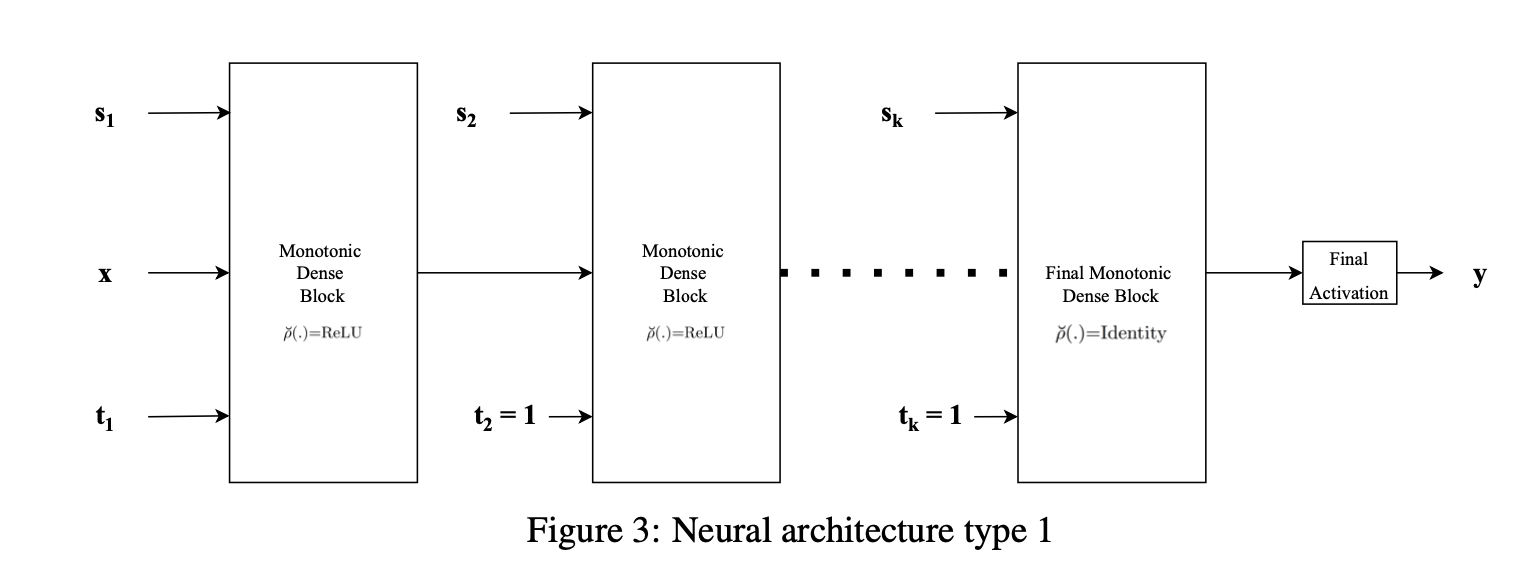

In [ ]:
def build_monotonic_type1_model(
    *,
    col_names: List[str],
    units: int,
    final_units: int,
    activation: Union[str, Callable[[TensorLike], TensorLike]],
    n_layers: int,
    final_activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
    monotonicity_indicator: Union[int, Dict[str, TensorLike]] = 1,
    is_convex: bool = False,
    is_concave: bool = False,
    dropout: Optional[float] = None,
) -> Model:
    # input
    x = [Input(shape=1, name=name) for name in sorted(col_names)]
    y = tf.keras.layers.Concatenate(name="inputs")(x)
    if isinstance(monotonicity_indicator, dict):
        monotonicity_indicator = [
            monotonicity_indicator[name] for name in sorted(col_names)
        ]

    y = create_mono_block(
        units=[units] * (n_layers - 1) + [final_units],
        activation=activation,
        monotonicity_indicator=monotonicity_indicator,
        is_convex=is_convex,
        is_concave=is_concave,
        dropout=dropout,
    )(y)

    if final_activation is not None:
        final_activation = tf.keras.activations.get(final_activation)
        y = final_activation(y)

    model = Model(inputs=x, outputs=y)
    return model

In [ ]:
n_layers = 4

model = build_monotonic_type1_model(
    col_names=list("abcd"),
    units=64,
    final_units=10,
    activation="elu",
    n_layers=n_layers,
    final_activation="softmax",
    monotonicity_indicator=dict(a=1, b=0, c=-1, d=0),
    is_convex=True,
    dropout=0.1,
)
model.summary()

mono_layers = [layer for layer in model.layers if isinstance(layer, MonoDense)]
assert len(mono_layers) == n_layers

# check monotonicity indicator
np.testing.assert_array_equal(
    mono_layers[0].monotonicity_indicator, np.array([1, 0, -1, 0]).reshape((-1, 1))
)
for i in range(1, n_layers):
    assert mono_layers[i].monotonicity_indicator == 1

# check convexity and concavity
for i in range(n_layers):
    assert mono_layers[i].is_convex
    assert not mono_layers[i].is_concave

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 a (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 b (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 d (InputLayer)                 [(None, 1)]          0           []                               
                                                                                            

### Type-2 architecture

The function `build_monotonic_type2_model()` can be used to build Neural Network models as shown in the figure below and is referred to in the paper as *Neural architecture type 2*. 

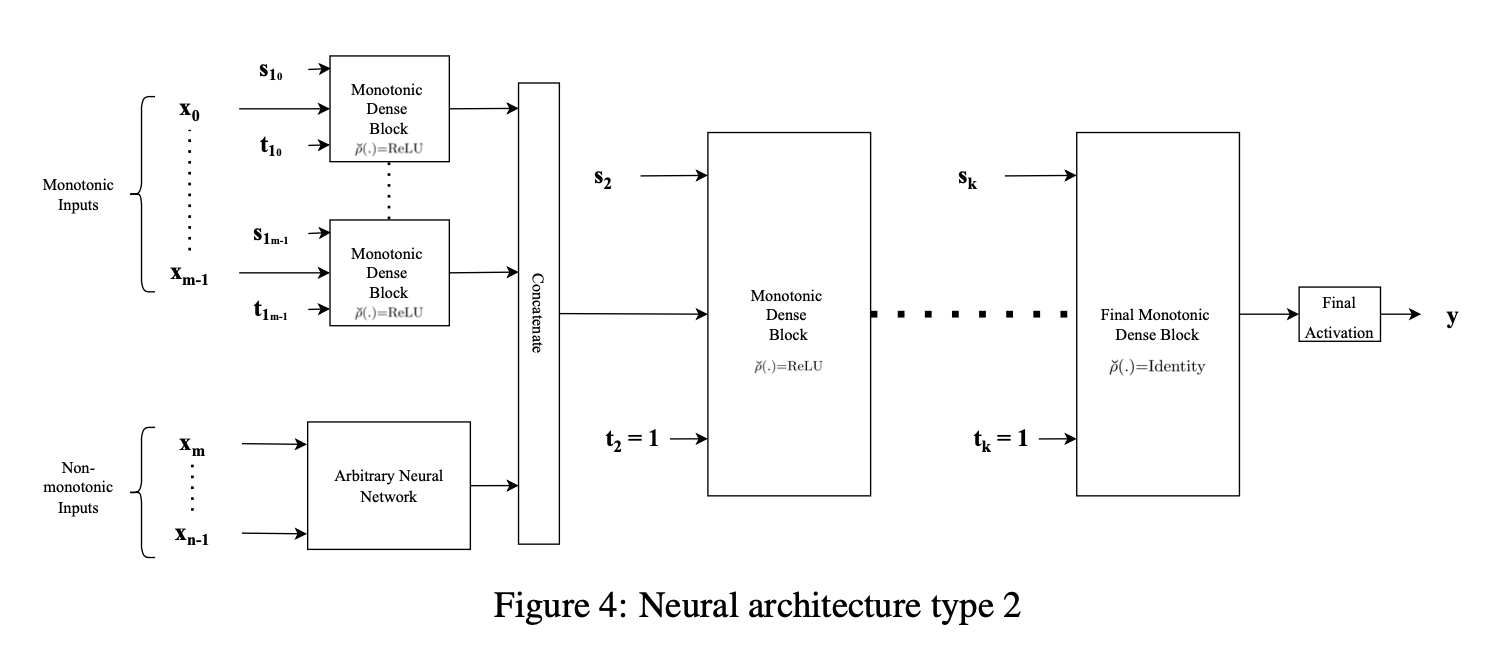

In [ ]:
def check_convexity_params(
    names: List[str],
    monotonicity_indicator: Dict[str, int],
    is_convex: Union[bool, Dict[str, bool]] = False,
    is_concave: Union[bool, Dict[str, bool]] = False,
) -> Tuple[Dict[str, bool], Dict[str, bool]]:
    if not isinstance(is_convex, dict):
        is_convex = {k: is_convex for k in names}
    if not isinstance(is_concave, dict):
        is_concave = {k: is_concave for k in names}

    # check keys
    if set(is_convex.keys()) != set(names):
        raise ValueError(f"{set(is_convex.keys())} != {set(names)}")
    if set(is_concave.keys()) != set(names):
        raise ValueError(f"{set(is_concave.keys())} != {set(names)}")

    # check compatibility
    convex_names = set([k for k in names if is_convex[k]])
    concave_names = set([k for k in names if is_concave[k]])
    incompatibles = convex_names.intersection(concave_names)
    if len(incompatibles) > 0:
        raise ValueError(
            f"Inputs {', '.join(sorted(incompatibles))} are set to be both concave and convex!"
        )

    # check monotonicity indicator
    for k, v in monotonicity_indicator.items():
        if v == 0 and (is_concave[k] or is_convex[k]):
            raise ValueError(
                "If monotonicity_indicator is 0, then is_concave and is_convex must be False, "
                + f"but we have: monotonicity_indicator['{k}'] = {monotonicity_indicator[k]}, "
                + f"is_convex['{k}'] = {is_convex[k]}, "
                + f"is_concave['{k}'] = {is_concave[k]}"
            )

    return is_convex, is_concave

In [ ]:
names = list("abcd")

expected = (
    {"a": False, "b": False, "c": False, "d": False},
    {"a": False, "b": False, "c": False, "d": False},
)
monotonicity_indicator = {"a": 0, "b": 1, "c": 0, "d": -1}
is_convex, is_concave = check_convexity_params(
    names, monotonicity_indicator, False, False
)
assert (is_convex, is_concave) == expected, (is_convex, is_concave)

monotonicity_indicator = {"a": 0, "b": 1, "c": 0, "d": -1}
with pytest.raises(ValueError) as e:
    is_convex, is_concave = check_convexity_params(
        names, monotonicity_indicator, True, False
    )
assert e.value.args == (
    "If monotonicity_indicator is 0, then is_concave and is_convex must be False, but we have: monotonicity_indicator['a'] = 0, is_convex['a'] = True, is_concave['a'] = False",
)

expected = (
    {"a": True, "b": True, "c": True, "d": True},
    {"a": False, "b": False, "c": False, "d": False},
)
monotonicity_indicator = {"a": -1, "b": 1, "c": 1, "d": -1}
is_convex, is_concave = check_convexity_params(
    names, monotonicity_indicator, True, False
)
assert (is_convex, is_concave) == expected, (is_convex, is_concave)

monotonicity_indicator = {"a": 0, "b": 1, "c": 0, "d": -1}
with pytest.raises(ValueError) as e:
    is_convex, is_concave = check_convexity_params(
        names, monotonicity_indicator, False, True
    )

expected = (
    {"a": False, "b": False, "c": False, "d": False},
    {"a": True, "b": True, "c": True, "d": True},
)
monotonicity_indicator = {"a": -1, "b": 1, "c": 1, "d": -1}
is_convex, is_concave = check_convexity_params(
    names, monotonicity_indicator, False, True
)
assert (is_convex, is_concave) == expected, (is_convex, is_concave)

with pytest.raises(ValueError) as e:
    check_convexity_params(names, monotonicity_indicator, True, True)
assert e.value.args == ("Inputs a, b, c, d are set to be both concave and convex!",)

In [ ]:
is_convex = {"a": False, "b": False, "c": False, "d": False}
is_concave = False

expected = (
    {"a": False, "b": False, "c": False, "d": False},
    {"a": False, "b": False, "c": False, "d": False},
)
monotonicity_indicator = {"a": 0, "b": 1, "c": 0, "d": -1}
is_convex, is_concave = check_convexity_params(
    names, monotonicity_indicator, is_convex, is_concave
)
assert (is_convex, is_concave) == expected, (is_convex, is_concave)

is_convex = {"a": False, "b": False, "c": False, "d": False}
is_concave = True

expected = (
    {"a": False, "b": False, "c": False, "d": False},
    {"a": True, "b": True, "c": True, "d": True},
)
monotonicity_indicator = {"a": -1, "b": 1, "c": 1, "d": -1}
is_convex, is_concave = check_convexity_params(
    names, monotonicity_indicator, is_convex, is_concave
)
assert (is_convex, is_concave) == expected, (is_convex, is_concave)

is_convex = {"a": False, "b": True, "c": False, "d": False}
is_concave = {"a": False, "b": False, "c": True, "d": False}

expected = (
    {"a": False, "b": True, "c": False, "d": False},
    {"a": False, "b": False, "c": True, "d": False},
)
is_convex, is_concave = check_convexity_params(
    names, monotonicity_indicator, is_convex, is_concave
)
assert (is_convex, is_concave) == expected, (is_convex, is_concave)

is_convex = {"a": False, "b": True, "c": False, "d": True}
is_concave = {"a": False, "b": False, "c": True, "d": True}

with pytest.raises(ValueError) as e:
    check_convexity_params(names, monotonicity_indicator, is_convex, is_concave)
assert e.value.args == ("Inputs d are set to be both concave and convex!",)

In [ ]:
from tensorflow.keras.layers import Concatenate


def build_monotonic_type2_model(
    *,
    col_names: List[str],
    input_units: Optional[int] = None,
    units: int,
    final_units: int,
    activation: Union[str, Callable[[TensorLike], TensorLike]],
    n_layers: int,
    final_activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
    monotonicity_indicator: Union[int, Dict[str, TensorLike]] = 1,
    is_convex: Union[bool, Dict[str, bool]] = False,
    is_concave: Union[bool, Dict[str, bool]] = False,
    dropout: Optional[float] = None,
):
    if isinstance(monotonicity_indicator, int):
        monotonicity_indicator = {name: monotonicity_indicator for name in col_names}

    if input_units is None:
        input_units = max(units // 4, 1)

    is_convex, is_concave = check_convexity_params(
        col_names, monotonicity_indicator, is_convex, is_concave
    )

    # inputs
    x = {name: Input(shape=1, name=name) for name in col_names}
    inputs = list(x.values())

    y = {
        name: (
            MonoDense(
                units=input_units,
                activation=activation,
                monotonicity_indicator=monotonicity_indicator[name],
                is_convex=is_convex[name],
                is_concave=is_concave[name],
                name=f"mono_dense_{name}"
                + (
                    "_increasing"
                    if monotonicity_indicator[name] == 1
                    else "_decreasing"
                )
                + ("_convex" if is_convex[name] else "")
                + ("_concave" if is_concave[name] else ""),
            )
            if monotonicity_indicator[name] != 0
            else Dense(units=input_units, activation=activation, name=f"dense_{name}")
        )(v)
        for name, v in x.items()
    }

    y = Concatenate()([y[k] for k in sorted(col_names)])

    if dropout and dropout > 0.0:
        y = Dropout(dropout)(y)

    has_convex = any(is_convex.values())
    has_concave = any(is_concave.values())
    if has_convex and has_concave:
        print("WARNING: we have both convex and concave parameters")

    y = create_mono_block(
        units=[units] * (n_layers - 1) + [final_units],
        activation=activation,
        monotonicity_indicator=1,
        is_convex=has_convex,
        is_concave=has_concave and not has_convex,
        dropout=dropout,
    )(y)

    if final_activation is not None:
        final_activation = tf.keras.activations.get(final_activation)
        y = final_activation(y)

    model = Model(inputs=inputs, outputs=y)

    return model

In [ ]:
for dropout in [False, True]:
    print("*" * 120)
    print()
    print(f"{dropout=}")
    print()
    model = build_monotonic_type2_model(
        col_names=list("abcd"),
        units=32,
        final_units=10,
        activation="elu",
        n_layers=4,
        dropout=dropout,
        monotonicity_indicator=dict(a=1, b=0, c=-1, d=0),
        is_convex=dict(a=True, b=False, c=False, d=False),
        is_concave=False,
    )
    model.summary()

************************************************************************************************************************

dropout=False

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 a (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 b (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 d (InputLayer)                 [(None, 1)]          0

                                                                 0][0]']                          
                                                                                                  
 mono_dense_2_increasing_convex  (None, 32)          1056        ['dropout_8[0][0]']              
  (MonoDense)                                                                                     
                                                                                                  
 dropout_9 (Dropout)            (None, 32)           0           ['mono_dense_2_increasing_convex[
                                                                 0][0]']                          
                                                                                                  
 mono_dense_3_increasing_convex  (None, 10)          330         ['dropout_9[0][0]']              
  (MonoDense)                                                                                     
          

## Experiments

For our experiments, we employ the datasets used by the authors of Certified Monotonic Network [1] and COMET [2]. We use the exact train-test split provided by the authors. Their respective repositories are linked below in the references. We directly load the saved train-test data split which have been saved after running the codes from respective papers' authors. 


References:


1.   Xingchao Liu, Xing Han, Na Zhang, and Qiang Liu. Certified monotonic neural networks. Advances in Neural Information Processing Systems, 33:15427–15438, 2020
  
  Github repo: https://github.com/gnobitab/CertifiedMonotonicNetwork



2.   Aishwarya Sivaraman, Golnoosh Farnadi, Todd Millstein, and Guy Van den Broeck. Counterexample-guided learning of monotonic neural networks. Advances in Neural Information Processing Systems, 33:11936–11948, 2020

  Github repo: https://github.com/AishwaryaSivaraman/COMET

In [ ]:
# download data if needed

data_path = Path("./data")

data_path.mkdir(exist_ok=True)

for name in ["auto", "blog", "compas", "heart", "loan"]:
    for prefix in ["train", "test"]:
        if not (data_path / f"{prefix}_{name}.csv").exists():
            !cd {data_path.resolve()}; wget https://zenodo.org/record/7968969/files/{prefix}_{name}.csv

!ls -lh {data_path}

total 114M
-rw-rw-r-- 1 davor davor  11K May 25 04:48 test_auto.csv
-rw-rw-r-- 1 davor davor  11M May 25 04:48 test_blog.csv
-rw-rw-r-- 1 davor davor  99K May 25 04:48 test_compas.csv
-rw-rw-r-- 1 davor davor  16K May 25 04:48 test_heart.csv
-rw-rw-r-- 1 davor davor  13M May 25 04:48 test_loan.csv
-rw-rw-r-- 1 davor davor  44K May 25 04:48 train_auto.csv
-rw-rw-r-- 1 davor davor  76M May 25 04:48 train_blog.csv
-rw-rw-r-- 1 davor davor 397K May 25 04:48 train_compas.csv
-rw-rw-r-- 1 davor davor  61K May 25 04:48 train_heart.csv
-rw-rw-r-- 1 davor davor  14M May 26 12:11 train_loan.csv
-rw-rw-r-- 1 davor davor  469 May 26 09:14 wget-log


Set the following flags to `True` to trigger search for hyperparametrs for particular dataset.

In [ ]:
should_find_hyperparam = dict(
    auto=False,
    heart=True,
    comet=True,
)

In [ ]:
def sanitize_col_names(df: pd.DataFrame) -> pd.DataFrame:
    columns = {c: c.replace(" ", "_") for c in df}
    df = df.rename(columns=columns)
    return df

In [ ]:
sanitize_col_names(pd.DataFrame({"a b": [1, 2, 3]}))

,a_b
0,1
1,2
2,3


In [ ]:
def get_train_n_test_data(
    dataset_name: str, *, data_path: Path = data_path
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_filename = "train_" + dataset_name + ".csv"
    train_df = pd.read_csv(data_path / train_filename)
    test_filename = "test_" + dataset_name + ".csv"
    test_df = pd.read_csv(data_path / test_filename)

    return sanitize_col_names(train_df), sanitize_col_names(test_df)

In [ ]:
train_df, test_df = get_train_n_test_data("auto")
train_df

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin,ground_truth
0,1.482807,1.073028,0.650564,0.606625,-1.275546,-1.631803,-0.701669,18.0
1,1.482807,1.482902,1.548993,0.828131,-1.452517,-1.631803,-0.701669,15.0
2,1.482807,1.044432,1.163952,0.523413,-1.275546,-1.631803,-0.701669,16.0
3,1.482807,1.025368,0.907258,0.542165,-1.806460,-1.631803,-0.701669,17.0
4,1.482807,2.235927,2.396084,1.587581,-1.983431,-1.631803,-0.701669,15.0
...,...,...,...,...,...,...,...,...
309,0.310007,0.358131,0.188515,-0.177437,-0.319901,1.720778,-0.701669,22.0
310,-0.862792,-0.566468,-0.530229,-0.722413,-0.921604,1.720778,-0.701669,36.0
311,-0.862792,-0.928683,-1.351650,-1.003691,3.184131,1.720778,0.557325,44.0
312,-0.862792,-0.566468,-0.530229,-0.810312,-1.417123,1.720778,-0.701669,32.0


In [ ]:
def df2ds(df: pd.DataFrame) -> tf.data.Dataset:
    x = df.to_dict("list")
    y = x.pop("ground_truth")

    ds = tf.data.Dataset.from_tensor_slices((x, y))

    return ds


def peek(ds: tf.data.Dataset) -> tf.Tensor:
    for x in ds:
        return x

In [ ]:
x, y = peek(df2ds(train_df).batch(8))
expected = {
    "Acceleration",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Model_Year",
    "Origin",
    "Weight",
}
assert set(x.keys()) == expected
for k in expected:
    assert x[k].shape == (8,)
assert y.shape == (8,)

In [ ]:
def build_mono_model_f(
    *,
    monotonicity_indicator: Dict[str, int],
    final_activation=None,
    loss,
    metrics,
    units: int,
    n_layers: int,
    activation: str,
    learning_rate: float,
    weight_decay: float,
    dropout: float,
    decay_rate: float,
    train_ds: tf.data.Dataset,
) -> Model:
    model = build_monotonic_type2_model(
        col_names=list(monotonicity_indicator.keys()),
        units=units,
        final_units=1,
        activation=activation,
        n_layers=n_layers,
        monotonicity_indicator=monotonicity_indicator,
        is_convex=False,
        is_concave=False,
        dropout=dropout,
        final_activation=final_activation,
    )

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate,
        decay_steps=len(train_ds),
        decay_rate=decay_rate,
        staircase=True,
    )

    optimizer = AdamW(learning_rate=lr_schedule, weight_decay=weight_decay)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [ ]:
def find_hyperparameters(
    build_model_f: Callable[..., Model],
    tuner_name: str = "BayesianOptimization",
    *,
    max_trials: Optional[int] = None,
    max_epochs: Optional[int] = None,
    train_ds: tf.data.Dataset,
    test_ds: tf.data.Dataset,
    objective: Union[str, Objective],
    dir_root: Union[Path, str],
    project_name: str,
    factor: int = 2,
    seed: int = 42,
    executions_per_trial: int = 1,
    hyperband_iterations: int = 1,
    max_consecutive_failed_trials: int = 5,
) -> Tuner:
    tf.keras.utils.set_random_seed(seed)

    if tuner_name == "BayesianOptimization":
        tuner = BayesianOptimization(
            build_model_f,
            objective=objective,
            max_trials=max_trials,
            seed=seed,
            directory=Path(dir_root) / datetime.now().isoformat(),
            project_name=project_name,
            executions_per_trial=executions_per_trial,
            max_consecutive_failed_trials=max_consecutive_failed_trials,
        )
        kwargs = dict(epochs=max_epochs)

    elif tuner_name == "Hyperband":
        tuner = Hyperband(
            build_model_f,
            objective=objective,
            max_epochs=max_epochs,
            factor=factor,
            seed=seed,
            directory=Path(dir_root) / datetime.now().isoformat(),
            project_name=project_name,
            executions_per_trial=executions_per_trial,
            hyperband_iterations=hyperband_iterations,
            max_consecutive_failed_trials=max_consecutive_failed_trials,
        )
        kwargs = dict()
    else:
        raise ValueError(f"tuner_name={tuner_name}")

    stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
    tuner.search(
        train_ds,
        validation_data=test_ds,
        callbacks=[stop_early],
        **kwargs,
    )

    return tuner

In [ ]:
# !ls /tmp/tuner/auto_tuner/2023-02-28T13:02:31.787216


def load_latest_tuner(
    build_model_f: Callable[..., Model],
    tuner_name: str = "BayesianOptimization",
    *,
    max_trials: Optional[int] = None,
    max_epochs: Optional[int] = None,
    train_ds: tf.data.Dataset,
    test_ds: tf.data.Dataset,
    objective: Union[str, Objective],
    dir_root: Union[Path, str],
    project_name: str,
    factor: int = 2,
    seed: int = 42,
    executions_per_trial: int = 1,
    hyperband_iterations: int = 1,
    max_consecutive_failed_trials: int = 5,
) -> Tuner:
    directory = sorted(Path(dir_root).glob("*"))[-1]
    print(f"Loading tuner saved at: {directory}")

    if tuner_name == "BayesianOptimization":
        tuner = BayesianOptimization(
            build_model_f,
            objective=objective,
            max_trials=max_trials,
            seed=seed,
            directory=directory,
            project_name=project_name,
            executions_per_trial=executions_per_trial,
            max_consecutive_failed_trials=max_consecutive_failed_trials,
        )
        kwargs = dict(epochs=max_epochs)
    elif tuner_name == "Hyperband":
        tuner = Hyperband(
            build_model_f,
            objective=objective,
            max_epochs=max_epochs,
            factor=factor,
            seed=seed,
            directory=directory,
            project_name=project_name,
            executions_per_trial=executions_per_trial,
            hyperband_iterations=hyperband_iterations,
            max_consecutive_failed_trials=max_consecutive_failed_trials,
        )
        kwargs = dict()
    else:
        raise ValueError(f"tuner_name={tuner_name}")

    return tuner

In [ ]:
def count_model_params(model: Model) -> int:
    return sum([sum([count_params(v) for v in l.variables]) for l in model.layers])


def create_model_stats(
    tuner: Tuner,
    hp: Dict[str, Any],
    *,
    epochs: int,
    num_runs: int = 10,
    train_ds: tf.data.Dataset,
    test_ds: tf.data.Dataset,
) -> pd.DataFrame:
    tf.keras.utils.set_random_seed(42)

    def model_stats(
        tuner: Tuner = tuner,
        hp: Dict[str, Any] = hp,
        epochs: int = epochs,
        train_ds: tf.data.Dataset = train_ds,
        test_ds: tf.data.Dataset = test_ds,
    ) -> Dict[str, Any]:
        model = tuner.hypermodel.build(hp)
        history = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=0)
        objective = history.history[tuner.oracle.objective.name]
        if tuner.oracle.objective.direction == "max":
            best_epoch = objective.index(max(objective))
        else:
            best_epoch = objective.index(min(objective))
        return objective[best_epoch]

    stats = pd.Series([model_stats() for _ in range(num_runs)])
    stats = stats.describe()
    stats = {
        f"{tuner.oracle.objective.name}_{k}": stats[k]
        for k in ["mean", "std", "min", "max"]
    }
    model = tuner.hypermodel.build(hp)
    stats = pd.DataFrame(
        dict(**hp.values, **stats, params=count_model_params(model)), index=[0]
    )
    #     display(stats)
    return stats


def create_tuner_stats(
    tuner: Tuner,
    *,
    epochs: int,
    num_runs: int,
    num_models: int,
    train_ds: tf.data.Dataset,
    test_ds: tf.data.Dataset,
) -> pd.DataFrame:
    stats = None

    for hp in tuner.get_best_hyperparameters(num_trials=num_models):
        new_entry = create_model_stats(
            tuner,
            hp,
            epochs=epochs,
            num_runs=num_runs,
            train_ds=train_ds,
            test_ds=test_ds,
        )
        if stats is None:
            stats = new_entry
        else:
            stats = pd.concat([stats, new_entry]).reset_index(drop=True)

        display(stats.sort_values(f"{tuner.oracle.objective.name}_mean"))

    return stats

In [ ]:
def hyperparameter_search(epochs, num_runs=10, num_models=10, **tuner_search_kwargs):
    tuner = find_hyperparameters(**tuner_search_kwargs)
    tuner = load_latest_tuner(**tuner_search_kwargs)

    stats = create_tuner_stats(
        tuner,
        epochs=epochs,
        num_runs=num_runs,
        num_models=num_models,
        train_ds=tuner_search_kwargs["train_ds"],
        test_ds=tuner_search_kwargs["test_ds"],
    )

    return stats, tuner

### Comparison with methods and datasets from COMET [1] (Reference #20 in our paper)


References:


1.   Aishwarya Sivaraman, Golnoosh Farnadi, Todd Millstein, and Guy Van den Broeck. Counterexample-guided learning of monotonic neural networks. Advances in Neural Information Processing Systems, 33:11936–11948, 2020

  Github repo: https://github.com/AishwaryaSivaraman/COMET



#### Experiment for Auto MPG dataset

The Auto MPG Dataset is a regression dataset [1] with 7 features - Cylinders, Displacement, Horsepower,Weight, Acceleration, Model Year, Origin. And the dependent variable is monotonically decreasing with
respect to features weigh, displacement, and horsepower. The `monotonicity_indicator` corresponding to these features are set to -1, since the relationship is a monotonically decreasing one with respect to the dependent variable.



References:

1. Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.
 
  https://archive.ics.uci.edu/ml/datasets/auto+mpg

2.   Aishwarya Sivaraman, Golnoosh Farnadi, Todd Millstein, and Guy Van den Broeck. Counterexample-guided learning of monotonic neural networks. Advances in Neural Information Processing Systems, 33:11936–11948, 2020


In [ ]:
auto_train_df, auto_test_df = get_train_n_test_data(
    data_path=data_path, dataset_name="auto"
)
display(auto_train_df)

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin,ground_truth
0,1.482807,1.073028,0.650564,0.606625,-1.275546,-1.631803,-0.701669,18.0
1,1.482807,1.482902,1.548993,0.828131,-1.452517,-1.631803,-0.701669,15.0
2,1.482807,1.044432,1.163952,0.523413,-1.275546,-1.631803,-0.701669,16.0
3,1.482807,1.025368,0.907258,0.542165,-1.806460,-1.631803,-0.701669,17.0
4,1.482807,2.235927,2.396084,1.587581,-1.983431,-1.631803,-0.701669,15.0
...,...,...,...,...,...,...,...,...
309,0.310007,0.358131,0.188515,-0.177437,-0.319901,1.720778,-0.701669,22.0
310,-0.862792,-0.566468,-0.530229,-0.722413,-0.921604,1.720778,-0.701669,36.0
311,-0.862792,-0.928683,-1.351650,-1.003691,3.184131,1.720778,0.557325,44.0
312,-0.862792,-0.566468,-0.530229,-0.810312,-1.417123,1.720778,-0.701669,32.0


In [ ]:
auto_train_ds = (
    df2ds(auto_train_df).repeat(10).shuffle(10 * auto_train_df.shape[0]).batch(16)
)
auto_test_ds = df2ds(auto_test_df).batch(16)

In [ ]:
def build_auto_model_f(
    **kwargs,
) -> Model:
    monotonicity_indicator = {
        "Cylinders": 0,
        "Displacement": -1,
        "Horsepower": -1,
        "Weight": -1,
        "Acceleration": 0,
        "Model_Year": 0,
        "Origin": 0,
    }

    metrics = "mse"
    loss = "mse"

    return build_mono_model_f(
        monotonicity_indicator=monotonicity_indicator,
        metrics=metrics,
        loss=loss,
        train_ds=auto_train_ds,
        **kwargs,
    )

In [ ]:
auto_model = build_auto_model_f(
    units=16,
    n_layers=3,
    activation="relu",
    dropout=0.1,
    weight_decay=0.1,
    learning_rate=0.1,
    decay_rate=0.8,
)
auto_model.summary()
auto_model.fit(
    auto_train_ds,
    validation_data=auto_test_ds,
    epochs=1,
)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Acceleration (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 Cylinders (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Displacement (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 Horsepower (InputLayer)        [(None, 1)]          0           []                               
                                                                                            

<keras.callbacks.History>

In [ ]:
def build_auto_model(hp) -> Model:
    return build_auto_model_f(
        units=hp.Int("units", min_value=8, max_value=32, step=1),
        n_layers=hp.Int("n_layers", min_value=1, max_value=4),
        activation=hp.Choice("activation", values=["elu"]),
        learning_rate=hp.Float(
            "learning_rate", min_value=1e-2, max_value=0.3, sampling="log"
        ),
        weight_decay=hp.Float(
            "weight_decay", min_value=1e-2, max_value=0.3, sampling="log"
        ),
        dropout=hp.Float("dropout", min_value=0.0, max_value=0.25, sampling="linear"),
        decay_rate=hp.Float(
            "decay_rate", min_value=0.1, max_value=1.0, sampling="reverse_log"
        ),
    )


def get_auto_tuner_search_kwargs(build_auto_model, *, max_trials, executions_per_trial):
    auto_tuner_search_kwargs = dict(
        build_model_f=build_auto_model,
        tuner_name="BayesianOptimization",
        train_ds=auto_train_ds,
        test_ds=auto_test_ds,
        objective=Objective("val_mse", direction="min"),
        max_epochs=5,
        executions_per_trial=executions_per_trial,
        dir_root="/tmp/tuner/auto_tuner",
        project_name="auto_tuner",
        max_trials=max_trials,
    )
    return auto_tuner_search_kwargs

In [ ]:
if should_find_hyperparam["auto"]:
    auto_tuner = find_hyperparameters(
        **get_auto_tuner_search_kwargs(
            build_auto_model, max_trials=100, executions_per_trial=5
        )
    )

In [ ]:
if should_find_hyperparam["auto"]:
    auto_stats = create_tuner_stats(
        auto_tuner,
        epochs=5,
        num_runs=10,
        num_models=10,
        train_ds=auto_train_ds,
        test_ds=auto_test_ds,
    )

In [ ]:
def final_build_auto_model(hp) -> Model:
    return build_auto_model_f(
        units=hp.Fixed("units", 16),
        n_layers=hp.Fixed("n_layers", 2),
        activation=hp.Fixed("activation", "elu"),
        learning_rate=hp.Fixed("learning_rate", 0.124332),
        weight_decay=hp.Fixed("weight_decay", 0.026992),
        dropout=hp.Fixed("dropout", 0.032543),
        decay_rate=hp.Fixed("decay_rate", 0.303206),
    )


final_auto_tuner = find_hyperparameters(
    **get_auto_tuner_search_kwargs(
        final_build_auto_model, max_trials=1, executions_per_trial=1
    )
)
final_auto_stats = create_tuner_stats(
    final_auto_tuner,
    epochs=5,
    num_runs=10,
    num_models=1,
    train_ds=auto_train_ds,
    test_ds=auto_test_ds,
)

Trial 1 Complete [00h 00m 09s]
val_mse: 8.385748863220215

Best val_mse So Far: 8.385748863220215
Total elapsed time: 00h 00m 09s
INFO:tensorflow:Oracle triggered exit


,units,n_layers,activation,learning_rate,weight_decay,dropout,decay_rate,val_mse_mean,val_mse_std,val_mse_min,val_mse_max,params
0,16,2,elu,0.124332,0.026992,0.032543,0.303206,8.427142,0.205446,8.088392,8.703953,537


#### Experiment for  Heart Disease  Dataset [1]

Heart Disease [1] is a classification dataset
used for predicting the presence of heart disease with 13 features (age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal)   and monotonically increasing with respect to features- trestbps and cholestrol (chol). The `monotonicity_indicator` corresponding to these features are set to 1. 



References:


1.   John H. Gennari, Pat Langley, and Douglas H. Fisher. Models of incremental concept formation. Artif. Intell., 40(1-3):11–61, 1989.

  https://archive.ics.uci.edu/ml/datasets/heart+disease

2.   Aishwarya Sivaraman, Golnoosh Farnadi, Todd Millstein, and Guy Van den Broeck. Counterexample-guided learning of monotonic neural networks. Advances in Neural Information Processing Systems, 33:11936–11948, 2020



In [ ]:
heart_train_df, heart_test_df = get_train_n_test_data(
    data_path=data_path, dataset_name="heart"
)
display(heart_train_df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,ground_truth
0,0.972778,0.649445,-2.020077,0.721008,-0.251855,2.426901,1.070838,-0.025055,-0.721010,0.986440,2.334348,-0.770198,-2.070238,0
1,1.415074,0.649445,0.884034,1.543527,0.740555,-0.410346,1.070838,-1.831151,1.381212,0.330395,0.687374,2.425024,-0.514345,1
2,1.415074,0.649445,0.884034,-0.649858,-0.326754,-0.410346,1.070838,-0.928103,1.381212,1.232457,0.687374,1.359950,1.041548,0
3,-1.902148,0.649445,-0.084003,-0.101512,0.066465,-0.410346,-0.953715,1.566030,-0.721010,1.970508,2.334348,-0.770198,-0.514345,0
4,-1.459852,-1.533413,-1.052040,-0.101512,-0.794872,-0.410346,1.070838,0.920995,-0.721010,0.248389,-0.959601,-0.770198,-0.514345,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,-0.243537,0.649445,-2.020077,-0.759528,-1.131917,-0.410346,1.070838,1.695037,-0.721010,-0.899690,0.687374,-0.770198,-2.070238,0
238,-1.238704,-1.533413,0.884034,0.008157,1.770414,2.426901,1.070838,-0.627087,1.381212,1.560480,0.687374,-0.770198,1.041548,1
239,1.193926,0.649445,0.884034,0.172661,0.141364,-0.410346,1.070838,-1.014108,-0.721010,1.396469,0.687374,0.294876,1.041548,1
240,-0.685833,0.649445,0.884034,-0.101512,0.178813,2.426901,1.070838,-0.025055,1.381212,-0.899690,-0.959601,1.359950,1.041548,1


In [ ]:
heart_train_ds = (
    df2ds(heart_train_df).repeat(10).shuffle(10 * heart_train_df.shape[0]).batch(16)
)
heart_test_ds = df2ds(heart_test_df).batch(16)

# peek(heart_train_ds), len(heart_train_ds)

(({'age': <tf.Tensor: shape=(16,), dtype=float32, numpy=
   array([-1.0175557 ,  0.41990736,  0.86220366,  0.5304814 ,  0.30933326,
          -1.3492779 , -0.02238897, -1.2387038 ,  0.5304814 , -0.02238897,
           1.5256481 , -0.24353713, -1.0175557 ,  1.0833519 ,  0.5304814 ,
          -1.3492779 ], dtype=float32)>,
   'sex': <tf.Tensor: shape=(16,), dtype=float32, numpy=
   array([ 0.64944535,  0.64944535, -1.5334127 ,  0.64944535,  0.64944535,
           0.64944535, -1.5334127 ,  0.64944535,  0.64944535,  0.64944535,
           0.64944535,  0.64944535, -1.5334127 ,  0.64944535,  0.64944535,
          -1.5334127 ], dtype=float32)>,
   'cp': <tf.Tensor: shape=(16,), dtype=float32, numpy=
   array([ 0.8840336,  0.8840336,  0.8840336, -2.0200768, -0.0840032,
           0.8840336, -0.0840032,  0.8840336, -2.0200768,  0.8840336,
           0.8840336, -2.0200768, -1.05204  ,  0.8840336, -1.05204  ,
          -0.0840032], dtype=float32)>,
   'trestbps': <tf.Tensor: shape=(16,), dtype=fl

In [ ]:
def build_heart_model_f(
    **kwargs,
) -> Model:
    monotonicity_indicator = {
        "age": 0,
        "sex": 0,
        "cp": 0,
        "trestbps": 1,
        "chol": 1,
        "fbs": 0,
        "restecg": 0,
        "thalach": 0,
        "exang": 0,
        "oldpeak": 0,
        "slope": 0,
        "ca": 0,
        "thal": 0,
    }

    metrics = "accuracy"
    loss = "binary_crossentropy"

    return build_mono_model_f(
        monotonicity_indicator=monotonicity_indicator,
        metrics=metrics,
        loss=loss,
        final_activation="sigmoid",
        train_ds=heart_train_ds,
        **kwargs,
    )

In [ ]:
heart_model = build_heart_model_f(
    units=16,
    n_layers=3,
    activation="relu",
    dropout=0.1,
    weight_decay=0.1,
    learning_rate=0.1,
    decay_rate=0.8,
)
heart_model.summary()
heart_model.fit(
    heart_train_ds,
    validation_data=heart_test_ds,
    epochs=1,
)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 ca (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 chol (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 cp (InputLayer)                [(None, 1)]          0           []                               
                                                                                           

                                                                                                  
 mono_dense_2_increasing (MonoD  (None, 1)           17          ['dropout_26[0][0]']             
 ense)                                                                                            
                                                                                                  
 tf.math.sigmoid (TFOpLambda)   (None, 1)            0           ['mono_dense_2_increasing[0][0]']
                                                                                                  
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
def build_heart_model(hp) -> Model:
    return build_heart_model_f(
        units=hp.Int("units", min_value=12, max_value=24, step=1),
        n_layers=hp.Int("n_layers", min_value=2, max_value=3),
        activation=hp.Choice("activation", values=["elu"]),
        learning_rate=hp.Float(
            "learning_rate", min_value=1e-2, max_value=0.3, sampling="log"
        ),
        weight_decay=hp.Float(
            "weight_decay", min_value=1e-2, max_value=0.3, sampling="log"
        ),
        dropout=hp.Float("dropout", min_value=0.0, max_value=0.5, sampling="linear"),
        decay_rate=hp.Float(
            "decay_rate", min_value=0.1, max_value=1.0, sampling="reverse_log"
        ),
    )


def get_heart_tuner_search_kwargs(
    build_heart_model, *, max_trials, executions_per_trial
):
    heart_tuner_search_kwargs = dict(
        build_model_f=build_heart_model,
        tuner_name="BayesianOptimization",
        train_ds=heart_train_ds,
        test_ds=heart_test_ds,
        objective=Objective("val_accuracy", direction="max"),
        max_epochs=10,
        executions_per_trial=executions_per_trial,
        dir_root="/tmp/tuner/heart_tuner",
        project_name="heart_tuner",
        max_trials=max_trials,
    )
    return heart_tuner_search_kwargs

In [ ]:
heart_tuner = find_hyperparameters(
    **get_heart_tuner_search_kwargs(
        build_heart_model, max_trials=100, executions_per_trial=5
    )
)

Trial 55 Complete [00h 01m 05s]
val_accuracy: 0.8590163946151733

Best val_accuracy So Far: 0.8688524603843689
Total elapsed time: 00h 55m 43s

Search: Running Trial #56

Value             |Best Value So Far |Hyperparameter
12                |16                |units
3                 |2                 |n_layers
elu               |elu               |activation
0.041365          |0.06543           |learning_rate
0.10878           |0.01              |weight_decay
0.18908           |0.25              |dropout
0.93403           |0.99983           |decay_rate

Epoch 1/10
152/152 [==============================] - 6s 11ms/step - loss: 0.3812 - accuracy: 0.8364 - val_loss: 0.3349 - val_accuracy: 0.8361
Epoch 2/10
152/152 [==============================] - 1s 9ms/step - loss: 0.3264 - accuracy: 0.8517 - val_loss: 0.3235 - val_accuracy: 0.8361
Epoch 3/10
152/152 [==============================] - 1s 9ms/step - loss: 0.3249 - accuracy: 0.8529 - val_loss: 0.3048 - val_accuracy: 0.8689
Epoch 4/10

KeyboardInterrupt: 

In [ ]:
create_tuner_stats(
    heart_tuner,
    epochs=5,
    num_runs=10,
    num_models=10,
    train_ds=heart_train_ds,
    test_ds=heart_test_ds,
)

In [ ]:
def final_build_heart_model(hp) -> Model:
    return build_heart_model_f(
        units=hp.Fixed("units", 16),
        n_layers=hp.Fixed("n_layers", 2),
        activation=hp.Fixed("activation", "elu"),
        learning_rate=hp.Fixed("learning_rate", 0.06543),
        weight_decay=hp.Fixed("weight_decay", 0.01),
        dropout=hp.Fixed("dropout", 0.25),
        decay_rate=hp.Fixed("decay_rate", 0.99983),
    )


final_heart_tuner = find_hyperparameters(
    **get_heart_tuner_search_kwargs(
        final_build_heart_model, max_trials=1, executions_per_trial=1
    )
)
create_tuner_stats(
    final_heart_tuner,
    epochs=5,
    num_runs=10,
    num_models=1,
    train_ds=heart_train_ds,
    test_ds=heart_test_ds,
)

Trial 1 Complete [00h 00m 15s]
val_accuracy: 0.9016393423080444

Best val_accuracy So Far: 0.9016393423080444
Total elapsed time: 00h 00m 15s
INFO:tensorflow:Oracle triggered exit


,units,n_layers,activation,learning_rate,weight_decay,dropout,decay_rate,val_accuracy_mean,val_accuracy_std,val_accuracy_min,val_accuracy_max,params
0,16,2,elu,0.06543,0.01,0.25,0.99983,0.855738,0.016931,0.836066,0.885246,969


,units,n_layers,activation,learning_rate,weight_decay,dropout,decay_rate,val_accuracy_mean,val_accuracy_std,val_accuracy_min,val_accuracy_max,params
0,16,2,elu,0.06543,0.01,0.25,0.99983,0.855738,0.016931,0.836066,0.885246,969


![Screenshot%202023-01-26%20at%2015.15.44.png](attachment:Screenshot%202023-01-26%20at%2015.15.44.png)

The figure above shows the table from our paper for reference. As can be seen from our experiments above, our proposed methodology performs comparable to or better than state-of-the-art

### Comparison with methods and datasets from Certified Monotonic Network [1] (Reference #20 in our paper)


References:


1.   Xingchao Liu, Xing Han, Na Zhang, and Qiang Liu. Certified monotonic neural networks. Advances in Neural Information Processing Systems, 33:15427–15438, 2020



#### Experiment for Compas Dataset [1]

COMPAS [1] is a dataset containing the criminal records of 6,172 individuals
arrested in Florida. The task is to predict whether the individual will commit a crime again
in 2 years. The probability predicted by the system will be used as a risk score. As mentioned in [2] 13 attributes for prediction. The risk score should be monotonically increasing w.r.t. four attributes, number of prior adult convictions, number of juvenile felony, number of juvenile misdemeanor, and number of other convictions. The `monotonicity_indicator` corresponding to these features are set to 1.

References: 

1. S. Mattu J. Angwin, J. Larson and L. Kirchner. Machine bias: There’s software used across the country to predict future criminals. and it’s biased against blacks. ProPublica, 2016.

2. Xingchao Liu, Xing Han, Na Zhang, and Qiang Liu. Certified monotonic neural networks. Advances in Neural Information Processing Systems, 33:15427–15438, 2020


In [ ]:
compas_train_df, compas_test_df = get_train_n_test_data(
    data_path=data_path, dataset_name="compas"
)
display(compas_train_df)

In [ ]:
# compas_train_ds = df2ds(compas_train_df).repeat(10).shuffle(10 * compas_train_df.shape[0]).batch(16)
# compas_test_ds = df2ds(compas_test_df).batch(16)

compas_train_ds = df2ds(compas_train_df).shuffle(compas_train_df.shape[0]).batch(16)
compas_test_ds = df2ds(compas_test_df).batch(16)

peek(compas_train_ds), len(compas_train_ds)

In [ ]:
def build_compas_model_f(
    **kwargs,
) -> Model:
    monotonicity_indicator = {
        "priors_count": 1,
        "juv_fel_count": 1,
        "juv_misd_count": 1,
        "juv_other_count": 1,
        "age": 0,
        "race_0": 0,
        "race_1": 0,
        "race_2": 0,
        "race_3": 0,
        "race_4": 0,
        "race_5": 0,
        "sex_0": 0,
        "sex_1": 0,
    }

    metrics = "accuracy"
    loss = "binary_crossentropy"

    return build_mono_model_f(
        monotonicity_indicator=monotonicity_indicator,
        metrics=metrics,
        loss=loss,
        final_activation="sigmoid",
        train_ds=compas_train_ds,
        **kwargs,
    )

In [ ]:
compas_model = build_compas_model_f(
    units=16,
    n_layers=3,
    activation="relu",
    dropout=0.1,
    weight_decay=0.1,
    learning_rate=0.1,
    decay_rate=0.8,
)
compas_model.summary()

In [ ]:
compas_model.fit(
    compas_train_ds,
    validation_data=compas_test_ds,
    epochs=2,
)

In [ ]:
def build_compas_model(hp) -> Model:
    return build_compas_model_f(
        units=hp.Int("units", min_value=8, max_value=32, step=1),
        n_layers=hp.Int("n_layers", min_value=1, max_value=3),
        activation=hp.Choice("activation", values=["elu"]),
        learning_rate=hp.Float(
            "learning_rate", min_value=1e-2, max_value=0.3, sampling="log"
        ),
        weight_decay=hp.Float(
            "weight_decay", min_value=1e-2, max_value=0.3, sampling="log"
        ),
        dropout=hp.Float("dropout", min_value=0.0, max_value=0.5, sampling="linear"),
        decay_rate=hp.Float(
            "decay_rate", min_value=0.1, max_value=1.0, sampling="reverse_log"
        ),
    )


def get_compas_tuner_search_kwargs(
    build_compas_model, *, max_trials, executions_per_trial
):
    compas_tuner_search_kwargs = dict(
        build_model_f=build_compas_model,
        tuner_name="BayesianOptimization",
        train_ds=compas_train_ds,
        test_ds=compas_test_ds,
        objective=Objective("val_accuracy", direction="max"),
        max_epochs=20,
        executions_per_trial=executions_per_trial,
        dir_root="/tmp/tuner/compas_tuner",
        project_name="compas_tuner",
        max_trials=max_trials,
    )
    return compas_tuner_search_kwargs

In [ ]:
compas_tuner = find_hyperparameters(
    **get_compas_tuner_search_kwargs(
        build_compas_model, max_trials=100, executions_per_trial=5
    )
)

#### Experiment for Blog Dataset [1]

Blog Feedback [1] is a dataset containing 54,270 data points from
blog posts. The raw HTML-documents of the blog posts were crawled and processed. The prediction
task associated with the data is the prediction of the number of comments in the upcoming 24 hours.
The feature of the dataset has 276 dimensions, and 8 attributes among them should be monotonically
non-decreasing with the prediction. They are A51, A52, A53, A54, A56, A57, A58, A59. Thus the `monotonicity_indicator` corresponding to these features are set to 1.  As done in [2], we only use the data points with targets smaller than the 90th percentile.




References:

1.   Krisztian Buza. Feedback prediction for blogs. In Data analysis, machine learning and knowledge discovery, pages 145–152. Springer, 2014
2.   Xingchao Liu, Xing Han, Na Zhang, and Qiang Liu. Certified monotonic neural networks. Advances in Neural Information Processing Systems, 33:15427–15438, 2020



In [ ]:
tf.keras.utils.set_random_seed(42)

monotonicity_indicator = np.zeros((276))
monotonicity_indicator[50:54] = 1.0
monotonicity_indicator[55:59] = 1.0

# convexity_indicator = None

train_params = dict(
    batch_size=256,
    num_epochs=100,
    units=4,
    n_layers=2,
    activation="elu",
    loss="mean_squared_error",
    metrics=tf.keras.metrics.RootMeanSquaredError(),
    learning_rate=0.01,
    is_classification=False,
)


history, monotonic_model = train_dataset(
    dataset_name="blog",
    monotonicity_indicator=monotonicity_indicator,
    #     convexity_indicator=convexity_indicator,
    train_params=train_params,
)

#### Experiment for Loan  Dataset [1]

Lending club loan *data*
contains complete loan data for all loans
issued through 2007-2015 of several banks. Each data point is a 28-dimensional feature including
the current loan status, latest payment information, and other additional features. The task is to
predict loan defaulters given the feature vector. The possibility of loan default should be nondecreasing w.r.t. number of public record bankruptcies, Debt-to-Income ratio, and
non-increasing w.r.t. credit score, length of employment, annual income. Thus the `monotonicity_indicator` corresponding to these features are set to 1.


References:

1. https://www.kaggle.com/wendykan/lending-club-loan-data (Note: Currently, the dataset seems to be withdrawn from kaggle)

In [ ]:
tf.keras.utils.set_random_seed(42)

# monotonicity_indicator = np.array([-1,  1, -1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
#   0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
monotonicity_indicator = np.array([-1, 1, -1, -1, 1] + [0] * 24)

convexity_indicator = None

train_params = dict(
    batch_size=256,
    num_epochs=20,
    units=4,
    n_layers=1,
    activation="elu",
    loss="binary_crossentropy",
    metrics="accuracy",
    learning_rate=0.008,
    is_classification=True,
)


history, monotonic_model = train_dataset(
    dataset_name="loan",
    monotonicity_indicator=monotonicity_indicator,
    #     convexity_indicator=convexity_indicator,
    train_params=train_params,
)

The figure above shows the table from our paper for reference. As can be seen from our experiments above, our proposed methodology performs comparable to or better than state-of-the-art

![Screenshot%202023-01-26%20at%2015.15.52.png](attachment:Screenshot%202023-01-26%20at%2015.15.52.png)